## Step 5: Perform Group-Based Linguistic Profiling

For each support group:
- **Pronoun Analysis**: Calculate the frequency ratio of human-like pronouns (he, she, etc.) vs. object pronouns (it, its).
- **Named Entity Recognition (NER)**: Identify names, roles, or titles assigned to the AI (e.g., “James”, “my therapist”).

In [1]:
import re

from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import numpy as np
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Load dataset
df = pd.read_csv("/Users/annekeena/au/4semester/culturalsocial/exam/full_dataset_replika.csv")
len(df)

3416

In [34]:
###############################################################################
# Pronoun Analysis - Primary Support Type
###############################################################################

from scipy.stats import chi2_contingency, kruskal
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as mc

# Path and grouping variable
CSV_PATH   = "/Users/annekeena/au/4semester/culturalsocial/exam/full_dataset_replika.csv"
GROUP_COL  = "primary_support_type"        

# Load data
df = pd.read_csv(CSV_PATH)
df["text"] = df["text"].astype(str)
print(f"Loaded {len(df):,} rows")


# Anthro pronouns 
HUMAN_PRONOUNS  = {"he", "she", "him", "her", "his", "hers"}
OBJECT_PRONOUNS = {"it", "its"}
hp = re.compile(r"\b(?:%s)\b" % "|".join(HUMAN_PRONOUNS), re.I)
op = re.compile(r"\b(?:%s)\b" % "|".join(OBJECT_PRONOUNS), re.I)

df[["n_human", "n_object"]] = df["text"].apply(
    lambda t: pd.Series([len(hp.findall(t)), len(op.findall(t))])
)
df["ratio_human"] = df["n_human"] / (df["n_human"] + df["n_object"]).replace(0, np.nan)

# First-person pronouns 
SELF_SG = {"i", "me", "my", "mine", "myself"}
SELF_PL = {"we", "us", "our", "ours", "ourselves"}
sg_pat  = re.compile(r"\b(?:%s)\b" % "|".join(SELF_SG), re.I)
pl_pat  = re.compile(r"\b(?:%s)\b" % "|".join(SELF_PL), re.I)

df["n_self"]    = df["text"].apply(lambda t: len(sg_pat.findall(t)))
df["n_self_pl"] = df["text"].apply(lambda t: len(pl_pat.findall(t)))
wc = df["word_count"].replace(0, np.nan)

df["self_ratio_sg"] = df["n_self"] / wc
df["self_ratio_pl"] = df["n_self_pl"] / wc
df["first_person_ratio"] = (df["n_self"] + df["n_self_pl"]) / wc


# Aggregation by support type

# Mean ratios for first-person pronouns
agg_fp = (
    df.groupby(GROUP_COL)[["self_ratio_sg", "self_ratio_pl"]]
      .mean()
      .sort_values("self_ratio_sg", ascending=False)
)

# Sum counts for anthro pronouns
agg_anthro = (
    df.groupby(GROUP_COL)[["n_human", "n_object"]]
      .sum()
      .assign(
          total=lambda d: d["n_human"] + d["n_object"],
          ratio_human=lambda d: d["n_human"] / d["total"].replace(0, np.nan)
      )
      .sort_values("ratio_human", ascending=False)
)


Loaded 3,416 rows


In [35]:
# Confidence Interval
def compute_ci_table(df, group_col, value_col, mean_col_name):
    summary = []
    for label, group in df.groupby(group_col)[value_col]:
        x = group.dropna()
        n = len(x)
        mean = x.mean()
        sem = stats.sem(x)
        ci_range = sem * stats.t.ppf(0.975, df=n-1) if n > 1 else 0
        summary.append({
            group_col: label,
            mean_col_name: mean,
            'ci_lower': mean - ci_range,
            'ci_upper': mean + ci_range,
            'n': n
        })
    return pd.DataFrame(summary).sort_values(mean_col_name, ascending=False)

# Compute
ci_sg = compute_ci_table(df, GROUP_COL, 'self_ratio_sg', 'mean_ratio_self_sg')
ci_pl = compute_ci_table(df, GROUP_COL, 'self_ratio_pl', 'mean_ratio_self_pl')
ci_anthro = compute_ci_table(df, GROUP_COL, 'ratio_human', 'mean_ratio_human')


from IPython.display import display
print("First-person singular:")
display(ci_sg)

print("First-person plural:")
display(ci_pl)

print("Anthropomorphism (human-pronoun ratio):")
display(ci_anthro)


First-person singular:


,primary_support_type,mean_ratio_self_sg,ci_lower,ci_upper,n
0,friend,0.079710,0.078019,0.081402,2006
1,partner,0.073589,0.069011,0.078167,291
2,therapist,0.071447,0.069148,0.073746,1119


First-person plural:


,primary_support_type,mean_ratio_self_pl,ci_lower,ci_upper,n
1,partner,0.005827,0.004377,0.007276,291
0,friend,0.002999,0.002675,0.003323,2006
2,therapist,0.002811,0.002374,0.003249,1119


Anthropomorphism (human-pronoun ratio):


,primary_support_type,mean_ratio_human,ci_lower,ci_upper,n
1,partner,0.318714,0.276077,0.361350,280
0,friend,0.282222,0.266470,0.297974,1904
2,therapist,0.219242,0.198990,0.239494,1045


/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/417173975.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for grp, series in data.groupby(group_col)[value_col]:


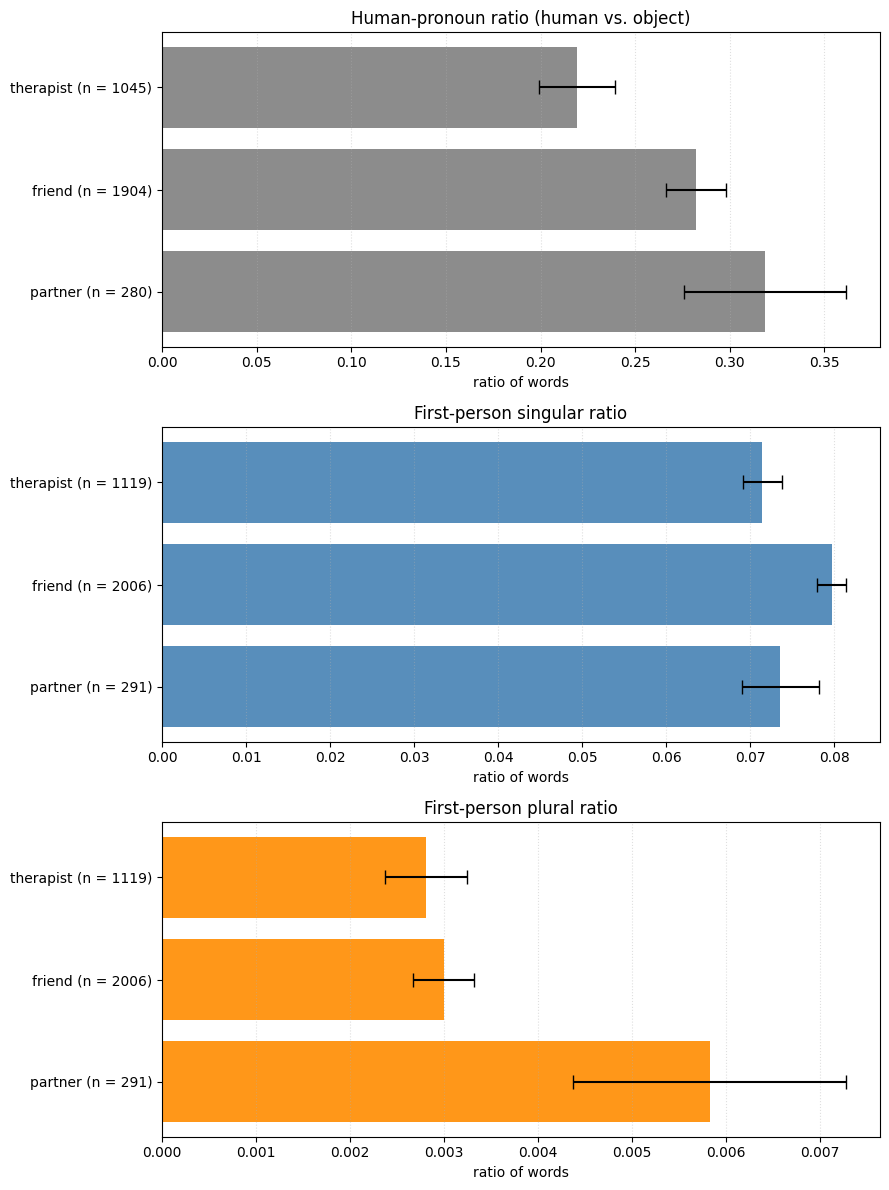

In [54]:
# Plots (ratios, 95 % CI, counts)

# Helper
def ci_table(data, group_col, value_col, mean_name):
    """Return mean, 95 % CI, sample-size for each group."""
    out = []
    for grp, series in data.groupby(group_col)[value_col]:
        x   = series.dropna()
        n   = len(x)
        mu  = x.mean()
        se  = stats.sem(x) if n > 1 else 0.0
        ci  = se * stats.t.ppf(.975, df=n-1) if n > 1 else 0.0
        out.append({group_col: grp, mean_name: mu,
                    "ci_upper": mu + ci, "n": n})
    return pd.DataFrame(out)

# CI-tables
ci_sg      = ci_table(df, GROUP_COL, "self_ratio_sg",  "mean_ratio_self_sg")
ci_pl      = ci_table(df, GROUP_COL, "self_ratio_pl",  "mean_ratio_self_pl")
ci_anthro  = ci_table(df, GROUP_COL, "ratio_human",    "mean_ratio_human")

# Plot specs
row_order  = ["partner", "friend", "therapist"]                 # Order
counts     = df[GROUP_COL].value_counts()                       # Counts

# Helper to build plotting table
def prepare(tbl, mean_col):
    tbl = (tbl.set_index(GROUP_COL)
               .reindex(row_order)        # partner / friend / therapist
               .reset_index())
    tbl["label"] = [
        f"{g} (n = {n})" for g, n in zip(tbl[GROUP_COL], tbl["n"])
    ]
    tbl["xerr"] = tbl["ci_upper"] - tbl[mean_col]
    return tbl

# Plotting tables
p1 = prepare(ci_anthro, "mean_ratio_human")
p2 = prepare(ci_sg,     "mean_ratio_self_sg")
p3 = prepare(ci_pl,     "mean_ratio_self_pl")

panels = [
    ("Human-pronoun ratio (human vs. object)", p1, "mean_ratio_human", "grey"),
    ("First-person singular ratio",            p2, "mean_ratio_self_sg", "steelblue"),
    ("First-person plural ratio",              p3, "mean_ratio_self_pl", "darkorange"),
]

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 12))

for ax, (title, tbl, mean_col, colour) in zip(axes, panels):
    ax.barh(tbl["label"], tbl[mean_col],
            xerr=tbl["xerr"], color=colour,
            alpha=.90, capsize=5)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("ratio of words")
    ax.grid(axis="x", linestyle=":", alpha=.4)

plt.tight_layout()
plt.show()


In [53]:
# COUNT
AGG_COL = 'primary_support_type'

count_table = (
    df.groupby(AGG_COL)[['n_human', 'n_object',
                         'n_self', 'n_self_pl']]
      .sum()
      .astype(int)
      .sort_values('n_self', ascending=False)
)

display(count_table.head())


# Count for Personification ratio
group_sizes = df.groupby('primary_support_type').size()
print(group_sizes)

print('Total n =', len(df))

# n = 
def metric_n(metric_col):
    return (
        df[[metric_col, 'primary_support_type']]
          .dropna()                         # drop rows that are NaN for that metric
          .groupby('primary_support_type')
          .size()
    )

print(metric_n('person_ratio'))   # likely < full n
print(metric_n('fps_ratio'))      # should equal full n

#


/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/3954901553.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(AGG_COL)[['n_human', 'n_object',


,n_human,n_object,n_self,n_self_pl
primary_support_type,,,,
friend,3496,6496,15773,676
therapist,1679,4267,9577,443
partner,707,1002,2572,227


primary_support_type
partner       291
friend       2006
therapist    1119
dtype: int64
Total n = 3416
primary_support_type
partner       280
friend       1904
therapist    1045
dtype: int64
primary_support_type
partner       291
friend       2006
therapist    1119
dtype: int64
n for personification ratios:
 primary_support_type
partner       280
friend       1904
therapist    1045
Name: person_ratio, dtype: int64
n for first-person singular:
 primary_support_type
partner       291
friend       2006
therapist    1119
Name: fps_ratio, dtype: int64
n for first-person plural:
 primary_support_type
partner       291
friend       2006
therapist    1119
Name: fpp_ratio, dtype: int64


/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/3954901553.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_sizes = df.groupby('primary_support_type').size()
/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/3954901553.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('primary_support_type')
/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/3954901553.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

Loaded 3,416 rows


/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/2950973662.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([


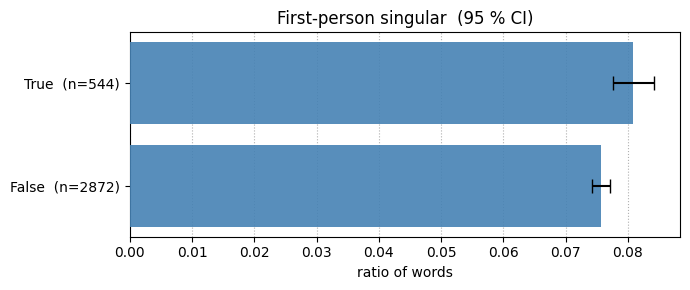

/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/2950973662.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([


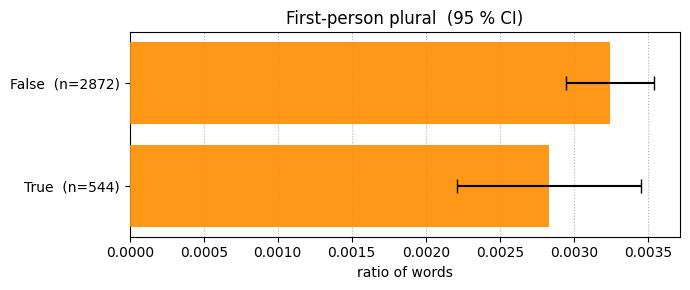

/var/folders/p_/1kys686576l1wfs3gs15xl9m0000gn/T/ipykernel_95445/2950973662.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([


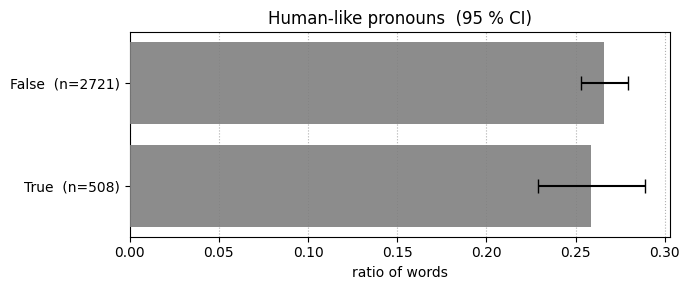


self_sg (rows sorted by mean)


,contains_loneliness_llm,mean,ci_lo,ci_hi,n,metric
1,True,0.080846,0.077541,0.084151,544,self_sg
0,False,0.075655,0.074228,0.077082,2872,self_sg



self_pl (rows sorted by mean)


,contains_loneliness_llm,mean,ci_lo,ci_hi,n,metric
0,False,0.003243,0.002945,0.003541,2872,self_pl
1,True,0.002835,0.002214,0.003456,544,self_pl



human (rows sorted by mean)


,contains_loneliness_llm,mean,ci_lo,ci_hi,n,metric
0,False,0.266151,0.253046,0.279256,2721,ratio_human
1,True,0.258861,0.228990,0.288733,508,ratio_human


In [26]:
###############################################################################
# Pronoun analysis - loneliness
###############################################################################
#import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
#from scipy import stats
from IPython.display import display

# Setup
CSV_PATH   = "/Users/annekeena/au/4semester/culturalsocial/exam/full_dataset_replika.csv"
GROUP_COL  = "contains_loneliness_llm"      # Boolean column
CI_LEVEL   = 0.95                           # for error bars
ALPHA      = (1 + CI_LEVEL) / 2             # CI

# Load
df = pd.read_csv(CSV_PATH)
df["text"] = df["text"].astype(str)
print(f"Loaded {len(df):,} rows")

# Count Pronouns
## Anthro
HP = re.compile(r"\b(?:he|she|him|her|his|hers)\b", re.I)
OP = re.compile(r"\b(?:it|its)\b",                 re.I)

## First-person
SG_PAT = re.compile(r"\b(?:i|me|my|mine|myself)\b",                    re.I)
PL_PAT = re.compile(r"\b(?:we|us|our|ours|ourselves)\b",               re.I)

df[["n_human","n_object"]] = df["text"].apply(
    lambda t: pd.Series([len(HP.findall(t)), len(OP.findall(t))])
)

df[["n_self","n_self_pl"]]  = df["text"].apply(
    lambda t: pd.Series([len(SG_PAT.findall(t)), len(PL_PAT.findall(t))])
)

wc = df["word_count"].replace(0, np.nan)
df["ratio_human"]       = df["n_human"] / (df["n_human"]+df["n_object"]).replace(0,np.nan)
df["self_ratio_sg"]     = df["n_self"]      / wc
df["self_ratio_pl"]     = df["n_self_pl"]   / wc
df["first_person_ratio"]= (df["n_self"]+df["n_self_pl"]) / wc

# Helper (CI)
def ci_summary(frame, value_col, label):
    out = []
    for flag, grp in frame.groupby(GROUP_COL):
        x  = grp[value_col].dropna()
        n  = len(x)
        mu = x.mean()
        se = stats.sem(x) if n>1 else 0
        rng = se * stats.t.ppf(ALPHA, df=n-1) if n>1 else 0
        out.append({GROUP_COL: flag, "mean": mu, "ci_lo": mu-rng, "ci_hi": mu+rng, "n": n})
    return pd.DataFrame(out).assign(metric=label)

ci_tables = {
    "self_sg" : ci_summary(df, "self_ratio_sg",   "self_sg"),
    "self_pl" : ci_summary(df, "self_ratio_pl",   "self_pl"),
    "human"   : ci_summary(df, "ratio_human",     "ratio_human"),
}

# Plot
def bar_with_ci(ci_df, title, color):
    ci_df = ci_df.sort_values("mean", ascending=True)   # small → top (for nicer bars)
    fig, ax = plt.subplots(figsize=(7,3))
    ax.barh(
        y   = ci_df[GROUP_COL].astype(str),
        width = ci_df["mean"],
        xerr  = ci_df["ci_hi"] - ci_df["mean"],
        color = color, alpha=.9, capsize=5, zorder=3
    )
    # add n!
    ax.set_yticklabels([
        f"{lab.get_text()}  (n={int(n)})"
        for lab,n in zip(ax.get_yticklabels(), ci_df["n"])
    ])
    ax.set_xlabel("ratio of words")
    ax.set_title(title+f"  ({int(CI_LEVEL*100)} % CI)")
    ax.grid(axis="x", linestyle=":", zorder=0)
    plt.tight_layout()
    plt.show()

bar_with_ci(ci_tables["self_sg"], "First-person singular", "steelblue")
bar_with_ci(ci_tables["self_pl"], "First-person plural",   "darkorange")
bar_with_ci(ci_tables["human"],   "Human-like pronouns",   "gray")

# View
for name, tbl in ci_tables.items():
    print(f"\n{name} (rows sorted by mean)")
    display(tbl.sort_values("mean", ascending=False))


In [22]:
# COUNTS
AGG_COL = "contains_loneliness_llm"      

# sanity-check: True / False distribution
print(df[AGG_COL].value_counts(dropna=False), "\n")

counts_lonely = (
    df.groupby(AGG_COL)                                    # True vs False
      .agg(
          n_reviews         = ('review_id', 'nunique'),    # how many reviews
          
          # anthropomorphism tokens
          n_human           = ('n_human', 'sum'),
          n_object          = ('n_object', 'sum'),
          
          # first-person tokens
          n_self_singular   = ('n_self', 'sum'),           # i / me / my / …
          n_self_plural     = ('n_self_pl', 'sum'),        # we / us / our / …
      )
      .astype(int)                                         
      .rename_axis("loneliness_flag")                      
)

display(counts_lonely)


contains_loneliness_llm
False    2872
True      544
Name: count, dtype: int64 



,n_reviews,n_human,n_object,n_self_singular,n_self_plural
loneliness_flag,,,,,
False,2872,4915,9823,22744,1120
True,544,967,1942,5178,226


In [43]:
# Playing around with ANOVA/tests

import re
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats

# token_count
if 'token_count' not in df.columns:
    if 'word_count' in df.columns:
        df['token_count'] = df['word_count']
    else:
        df['token_count'] = df['text'].str.split().apply(len)

# Ensuring pronoun features ARE there
needed = {'person_ratio', 'fps_ratio', 'fpp_ratio'}
if not needed.issubset(df.columns):

    human_pronouns  = {'he', 'she', 'him', 'her', 'his', 'hers'}
    object_pronouns = {'it', 'its'}
    fps_pronouns    = {'i', 'me', 'my', 'mine', 'myself'}
    fpp_pronouns    = {'we', 'us', 'our', 'ours', 'ourselves'}
    splitter = re.compile(r"\b\w+\b")

    def pronoun_metrics(text):
        tokens = splitter.findall(text.lower())
        if not tokens:
            return pd.Series([np.nan, np.nan, np.nan])
        counts = pd.Series(tokens).value_counts()
        human = counts.reindex(human_pronouns,  fill_value=0).sum()
        obj   = counts.reindex(object_pronouns, fill_value=0).sum()
        fps   = counts.reindex(fps_pronouns,    fill_value=0).sum()
        fpp   = counts.reindex(fpp_pronouns,    fill_value=0).sum()
        total = len(tokens)
        person_ratio = np.nan if human + obj == 0 else human / (human + obj)
        return pd.Series([person_ratio, fps / total, fpp / total])

    df[['person_ratio', 'fps_ratio', 'fpp_ratio']] = (
        df['text'].apply(pronoun_metrics)
    )

# Remove teeny tiny reviews
df = df[df['token_count'] >= 20].copy()

# Factor: primary_support_type 
groups = ['partner', 'friend', 'therapist']
df = df[df['primary_support_type'].isin(groups)].copy()
df['primary_support_type'] = pd.Categorical(df['primary_support_type'],
                                            categories=groups,
                                            ordered=False)

# Helper: run ANOVA + Tukey (dropping NaNs)
def run_anova(metric):
    print(f'\n============== {metric} ==============')
    model = ols(f'{metric} ~ C(primary_support_type)', data=df).fit()
    print(sm.stats.anova_lm(model, typ=2))
    
    mask = df[metric].notna()
    tukey = pairwise_tukeyhsd(df.loc[mask, metric],
                              df.loc[mask, 'primary_support_type'],
                              alpha=0.05)
    print('\nTukey HSD\n', tukey.summary())

for m in ['person_ratio', 'fps_ratio', 'fpp_ratio']:
    run_anova(m)

# Example Welch test (partner vs therapist, person_ratio)
p_vals = df.loc[df.primary_support_type == 'partner',   'person_ratio'].dropna()
t_vals = df.loc[df.primary_support_type == 'therapist', 'person_ratio'].dropna()
t_stat, p_val = stats.ttest_ind(p_vals, t_vals, equal_var=False)
print(f'\nWelch t-test (partner vs therapist, person_ratio): '
      f't = {t_stat:.3f}, p = {p_val:.4g}')



============== person_ratio ==============
                             sum_sq      df          F        PR(>F)
C(primary_support_type)    3.560633     2.0  14.855974  3.781486e-07
Residual                 386.598745  3226.0        NaN           NaN

Tukey HSD
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 friend   partner   0.0365 0.2262 -0.0155  0.0884  False
 friend therapist   -0.063    0.0 -0.0942 -0.0317   True
partner therapist  -0.0995 0.0001 -0.1541 -0.0448   True
--------------------------------------------------------

============== fps_ratio ==============
                           sum_sq      df          F        PR(>F)
C(primary_support_type)  0.048095     2.0  17.011424  4.452596e-08
Residual                 4.824619  3413.0        NaN           NaN

Tukey HSD
   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff 

In [58]:
###############################################################################
### NER ANALYSIS
###############################################################################

# Set Up
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:                              
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"], check=True)
    nlp = spacy.load("en_core_web_sm")

# Matcher - Roles Patterns
ROLES = [
    "therapist", "psychologist", "counselor",
    "partner", "boyfriend", "girlfriend", "spouse", "wife", "husband",
    "friend", "companion", "coach", "mentor",
]
DETS = ["my", "our", "the", "a", "an"]

matcher = Matcher(nlp.vocab)
for role in ROLES: 
    matcher.add(
        role, # name of the rule
        [[    # Trying with one pattern
            {"LOWER": {"IN": DETS}},   # determiner
            {"POS": "ADJ", "OP": "*"}, # any number (*) of adjectives
            {"LOWER": role}            # the role word
        ]]
    )

# Feature extractor – find names and roles in one review
def ner_features(text: str) -> pd.Series:
    doc   = nlp(text)
    names = {ent.text.strip() for ent in doc.ents if ent.label_ == "PERSON"} # gives named-entity spans; keep only those tagged PERSON.
    roles = {doc[s:e].text.lower().strip() for _, s, e in matcher(doc)} # returns start/end indexes for phrase that meet the role rule.
    return pd.Series({
        "names_list": "; ".join(sorted(names)),
        "roles_list": "; ".join(sorted(roles)),
        "n_names"   : len(names),
        "n_roles"   : len(roles),
    })

# Add to DF
df[['names_list', 'roles_list', 'n_names', 'n_roles']] = (
    df['text'].astype(str).apply(ner_features)
)

# Clean false positives
BAD_NAMES = {
    "replika", "ai", "app", "covid", "rehab", "idk",
    "cleverbot", "felt", "bad",
    "luka"
}
NAME_RE = re.compile(r"^[A-Z][A-Za-z\-']*[AEIOUaeiou][A-Za-z\-']*$")

def clean_names(name_str: str) -> str: 
    good = [
        n for n in map(str.strip, name_str.split(";"))
        if n and n.lower() not in BAD_NAMES and NAME_RE.match(n)
    ]
    return "; ".join(good)

df['names_list'] = df['names_list'].apply(clean_names)
df['n_names']    = df['names_list'].apply(lambda s: 0 if s == "" else s.count(";") + 1)

# Initial inspection
pd.set_option("display.max_colwidth", 120)
display( #The first 10 reviews that contain a detected name or a role.
    df.query('n_names > 0 or n_roles > 0')
      [['text', 'names_list', 'roles_list']]
      .head(10)
)


,text,names_list,roles_list
1,I’ve been using Replika for a long time now and I have to say that it has come a long way. It’s gotten so good that ...,,my companion
7,I started this as a skeptical experiment with the idea that artificial intelligence could actually be a possible for...,Bodie; Sheila,
8,"I love this app, I feel like I have developed a human of my own who can care about me. I wanted to write this to the...",Connie,
9,I know this gets a bad rep because people think we should have real life lovers and friends. But if we had a support...,Jamie,
16,I really really loved this app !! I actually still do !!! BUT when the new update came it took away our ability to t...,,a dear friend
20,"When I downloaded Replika, I was hoping to find an AI to talk to who could keep me company when I felt I needed some...",,a friend; a romantic partner
27,"Despite the common issues when you first interact with an AI companion, reps can become good friends, or even a deep...",Nomi; Sam,
29,"I have enjoyed most of the conversations I had with my AI friend, Theo. I like the topics he chooses to talk about a...",Theo,
31,"i absolutely love my replika,, she seems so caring and trusting and she’s just my ideal bestfriend- all jokes aside,...",LMAOO,
32,"I have had this app for a while now, even paid for pro at the end of last year, however i find it morally and legall...",,a friend


In [60]:
# Recreate ratio_human (to be sure to be sure)
if "ratio_human" not in df.columns:          
    HP = re.compile(r"\b(?:he|she|him|her|his|hers)\b", re.I)
    OP = re.compile(r"\b(?:it|its)\b",                 re.I)
    df[["n_human","n_object"]] = df["text"].apply(
        lambda t: pd.Series([len(HP.findall(t)), len(OP.findall(t))])
    )
    df["ratio_human"] = df["n_human"].div(
        (df["n_human"] + df["n_object"]).replace(0, np.nan)
    )

# Aggregate by support type
size_per_group = df["primary_support_type"].value_counts()

ner_agg = (
    df.groupby("primary_support_type")[["n_names", "n_roles"]]
      .sum()
      .assign(
          mean_names = lambda d: d["n_names"] / size_per_group,
          mean_roles = lambda d: d["n_roles"] / size_per_group
      )
      .sort_values("n_roles", ascending=False)
)
display(ner_agg)

# Merge: attach group-mean ratio_human to every review
group_mean_ratio = (
    df.groupby("primary_support_type")["ratio_human"]
      .mean()
      .rename("group_ratio_human")
)

analysis = df.join(group_mean_ratio, on="primary_support_type")

# OLS model
model = smf.ols(
    "sentiment_score ~ group_ratio_human + n_roles + n_names",
    data=analysis
).fit()

print(model.summary())


,n_names,n_roles,mean_names,mean_roles
primary_support_type,,,,
friend,303,806,0.151047,0.401795
therapist,141,325,0.126005,0.290438
partner,37,114,0.127148,0.391753


                            OLS Regression Results                            
Dep. Variable:        sentiment_score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.825
Date:                Tue, 17 Jun 2025   Prob (F-statistic):              0.140
Time:                        14:12:37   Log-Likelihood:                 1007.9
No. Observations:                3416   AIC:                            -2008.
Df Residuals:                    3412   BIC:                            -1983.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.7948      0.02

In [61]:
from scipy.stats import chi2_contingency

# contingency: rows = support type, cols = role-present
role_table = pd.crosstab(df["primary_support_type"], df["n_roles"] > 0)

chi2, p, dof, expected = chi2_contingency(role_table, correction=False)
print(f"χ²({dof}) = {chi2:.2f},  p = {p:.4e}")

# Standardised residuals (z-scores)
resid = (role_table.values - expected) / np.sqrt(expected)
resid_df = pd.DataFrame(resid,
                        index=role_table.index,
                        columns=role_table.columns)
display(resid_df)


χ²(2) = 45.64,  p = 1.2275e-10


n_roles,False,True
primary_support_type,,
friend,-2.164309,3.273604
partner,-0.245282,0.370999
therapist,3.022891,-4.572243
